In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


11490434/11490434 [==============================] - 0s 0us/step


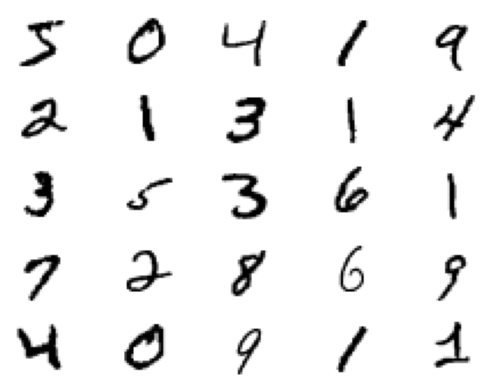

In [ ]:
# Carga del dataset mnist
from keras.datasets.mnist import load_data
from matplotlib import pyplot
# Carga de las imágenes en memoria
(trainX, trainy), (testX, testy) = load_data()
# dibujamos las imagenes del dataset de entrenamiento
for i in range(25):
  pyplot.subplot(5, 5, 1 + i)
  pyplot.axis('off')
  pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import ReLU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.regularizers import l1
from matplotlib import pyplot


def define_discriminator(in_shape=(28,28,1)):
  model = Sequential()
  model.add(Conv2D(32, (3,3), strides=(2, 2), padding='same', input_shape=in_shape,kernel_regularizer=l1(0.0001)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.3))
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same',kernel_regularizer=l1(0.0001)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
def define_generator(latent_dim):
  model = Sequential()
  n_nodes = 128 * 7 * 7
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  model.add(Reshape((7, 7, 128)))
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
  return model

In [ ]:
# definimos el modelo combinado de de generador y discriminador
def define_gan(g_model, d_model):
  # hacemos los pesos del discriminador no entrenables
  d_model.trainable = False
  # los conectamos
  model = Sequential()
  # añadimos el generador
  model.add(g_model)
  # añadimos el discriminador
  model.add(d_model)
  # compilamos el modelo
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [ ]:
# cargamos y preparamos las imagenes de entrenamiento mnist
def load_real_samples():
  # cargamos el dataset mnist
  (trainX, _), (_, _) = load_data()
  # expandimos a 3 dimensiones, canal y dimensiones
  X = expand_dims(trainX, axis=-1)
  X = X.astype('float32')
  # escalamos de [0,255] a [0,1]
  X = X / 255.0
  return X

In [ ]:
# seleccionamos ejemplos reales
def generate_real_samples(dataset, n_samples):
  # elegimos instancias aleatorias
  ix = randint(0, dataset.shape[0], n_samples)
  # recuperamos las instancias elegidas
  X = dataset[ix]
  # generamos etiquetas 'real'
  y = ones((n_samples, 1))
  return X, y

In [ ]:
# generamos puntos en el espacio latente como entrada para el generador
def generate_latent_points(latent_dim, n_samples):
  # generamos puntos en el espacio latente
  x_input = randn(latent_dim * n_samples)
  # redimensionamos en un conjunto de entradas para la red
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [ ]:
# Usamos el generador para generar n ejemplos fake, con su etiqueta 'fake'
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generamos puntos en el espacio latente
  x_input = generate_latent_points(latent_dim, n_samples)
  # predecimos las salidas
  X = g_model.predict(x_input)
  # creamos etiquetas 'fake'
  y = zeros((n_samples, 1))
  return X, y

In [ ]:
# creamos y salvamos un gráfico de imágenes generadas.
def save_plot(examples, epoch, n=10):
  # dibujamos imagenes
  for i in range(n * n):
    pyplot.subplot(n, n, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
  filename = '/content/drive/MyDrive/TFG/tfg_pesos_2/generated_plot_e%03d.png' % (epoch+1)
  pyplot.savefig(filename)
  pyplot.close()


In [ ]:
# evaluamos el discriminador, dibujamos las imágenes generadas, guardamos el modelo generador
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
  # preparamos los ejemplos reales
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluamos el discriminador con ejemplos reales
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # preparamos los ejemplos fake
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluamos el discriminador con ejemplos fake
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # resumimos el desempeño del discriminador
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # guardamos el dibujo
  save_plot(x_fake, epoch)
  # guardamos el generador
  filename = '/content/drive/MyDrive/TFG/tfg_pesos_2/generator_model_%03d.h5' % (epoch + 1)
  g_model.save(filename)

In [ ]:
# entrenamos el generador y el discriminador
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # enumeramos las epochs
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      # obtenemos ejemplos reales
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generamos ejemplos fake
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # creamos conjunto de entrenamiento para el discriminador
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # actualizamos los pesos del discriminador
      d_loss, _ = d_model.train_on_batch(X, y)
      # preparamos los puntos del espacio latente como entrada para el generador
      X_gan = generate_latent_points(latent_dim, n_batch)
      # creamos etiquetas invertidas para los ejemplos fake
      y_gan = ones((n_batch, 1))
      # actualiza el generador por via del error del discriminador
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    # evalua el desempeño del modelo
    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
# tamaño del espacio latente
latent_dim = 100
# creamos el discriminador
d_model = define_discriminator()
# creamos el generador
g_model = define_generator(latent_dim)
# creamos la gan
gan_model = define_gan(g_model, d_model)
# cargamos las imágenes
dataset = load_real_samples()
# entrenamos el modelo
train(g_model, d_model, gan_model, dataset, latent_dim)

Output hidden; open in https://colab.research.google.com to view.

1/1 [==============================] - 0s 385ms/step


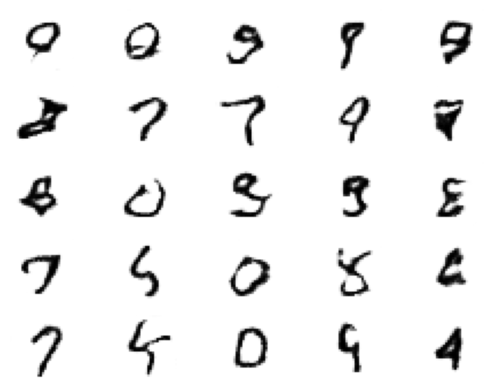

In [ ]:
# ejemplo de carga del generador y generación de imágenes
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generamos puntos en el espacio latente como entrada para el generador
def generate_latent_points(latent_dim, n_samples):
  # generamos puntos en el espacio latente
  x_input = randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

# creamos y guardamos un dibujo de imagenes generadas
def save_plot(examples, n):
  # dibujamos imagenes
  for i in range(n * n):
    pyplot.subplot(n, n, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
  pyplot.show()

# cargamos el modelo
model = load_model('/content/drive/MyDrive/TFG/tfg_pesos_2/generator_model_100.h5')
# generamos imágenes
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
# dibujamos resultados
save_plot(X, 5)